In [1]:
#import Pkg
#Pkg.add("JuMP")
#Pkg.add("GLPK")
#Pkg.add("Gruobi")
#Pkg.add("DataFrames")
#Pkg.add("CSV")

In [2]:
using JuMP, GLPK
using DataFrames
using CSV

In [3]:
#load cost data
con_generation = CSV.File("../data/conventional_generators.csv") |> DataFrame

#load wind_technicaldata
wind_generation = CSV.File("../data/wind_farms.csv") |> DataFrame

# load wind profile
wind_profile = CSV.File("../data/wind_powerprofile_200.csv") |> DataFrame


Row,Hour,W1,W2,W3,W4,W5,W6
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,76.8921,101.54,92.8003,95.3709,96.002,70.9073
2,2,66.8277,90.9989,109.167,107.937,103.616,112.618
3,3,78.422,116.959,142.88,134.78,128.276,133.832
4,4,64.1437,134.249,159.57,133.664,142.969,154.233
5,5,102.22,145.507,160.944,165.303,144.03,161.49
6,6,134.039,131.112,157.023,161.828,144.636,155.222
7,7,146.517,153.67,141.566,159.927,152.86,153.604
8,8,143.176,163.392,155.294,170.805,158.643,164.307
9,9,163.297,144.48,172.638,185.318,150.901,166.558


In [4]:
#demand bids
name = "demand_hour_0.csv"
demand_bids = CSV.File("../data/demand_bids_hour/" * name) |> DataFrame
 
# number of convential generators
G = size(con_generation, 1)

# number of demand
D = size(demand_bids, 1)

# number of wind generators
W = size(wind_generation, 1)

4

In [5]:
# Initialize the DataFrame directly without dynamic column names
result_df = DataFrame(hour = Int[], objective_value = Float64[])
equilibrium_df = DataFrame(hour = Int[], market_price = Float64[], market_quantity = Float64[])

# For x variables, manually add each column. This is a one-time setup.
for i in 1:G
    result_df[!, Symbol("x_con$i")] = Float64[]
end

# For w variables, manually add each column. This is a one-time setup.
for i in 1:W
    result_df[!, Symbol("x_wind$i")] = Float64[]
end

# For y variables, manually add each column. This is a one-time setup.
for i in 1:D
    result_df[!, Symbol("y$i")] = Float64[]
end

In [6]:
# Load demand bids data
demand_bids_all = [CSV.File("../data/demand_bids_hour/demand_hour_$(i-1).csv") |> DataFrame for i in 1:24]

# Create a new model with GLPK solver
model = Model(GLPK.Optimizer)

# Define the decision variables for every generator and hour
@variable(model, x_con[1:G, 1:24] >= 0)  # Power output variable for conventional generators
@variable(model, x_wind[1:W, 1:24] >= 0)  # Power output variable for wind generators
@variable(model, y[1:D, 1:24] >= 0)  # Demand variable


# Add constraints for each plant
for g in 1:G
    for hour in 1:24
        @constraint(model, x_con[g, hour] <= con_generation[g, 6])  # Set the upper bound
        @constraint(model, x_con[g, hour] >= 0)  # Set the lower bound
    end
end

# Add constraints for each wind farm
for w in 1:W
    for hour in 1:24
        @constraint(model, x_wind[w, hour] <= wind_profile[hour, w+1])  # Set the upper bound
        @constraint(model, x_wind[w, hour] >= 0)  # Set the lower bound
    end
end

# Add constraints for each demand bid
for d in 1:D
    for hour in 1:24
        @constraint(model, y[d, hour] <= demand_bids_all[hour][d, 2])  # Set the upper bound
        @constraint(model, y[d, hour] >= 0)  # Set the lower bound
    end
end

# Add temporary for each generator
for g in 1:G
    for hour in 2:24
        @constraint(model, x_con[g, hour] <= x_con[g, hour - 1] + con_generation[g, 7])  # Set the upper bound
        @constraint(model, x_con[g, hour] >= x_con[g, hour - 1] - con_generation[g, 8])  # Set the lower bound
    end
end

# Define the objective function
@objective(model, Max, sum(demand_bids_all[hour][d, 3] * y[d, hour] for hour in 1:24, d in 1:D) -
                     sum(con_generation[g, 3] * x_con[g, hour] for hour in 1:24, g in 1:G))

# Add the constraint for the balance between supply and demand for each hour
@constraint(model, [hour = 1:24], sum(x_con[g, hour] for g in 1:G) + sum(x_wind[w, hour] for w in 1:W) -
                                     sum(y[d, hour] for d in 1:D) == 0)

# Solve the model
optimize!(model)

# Check the status of the solution
status = termination_status(model)
if status == MOI.OPTIMAL
    println("Optimal solution found")
    # Retrieve and print the values of the decision variables
    x_con_optimal = value.(x_con)
    x_wind_optimal = value.(x_wind)
    y_optimal = value.(y)
else
    println("No optimal solution found")
end


Optimal solution found


17×24 Matrix{Float64}:
  85.6092    0.0       0.0       0.0     …  106.053    93.2757   80.4982
   0.0       0.0       0.0      39.116       55.0276   48.3978   41.768
   0.0       0.0       0.0      68.9864      97.0487   85.3561    0.0
 106.608   100.243     0.0       0.0        132.066   116.155     0.0
  46.8428    0.0       0.0       0.0         58.0291   51.0377   44.0462
   0.0     105.559   100.532    37.3419  …    0.0       0.0       0.0
  67.8413    0.0      60.7534    0.0          0.0      73.9166   63.7911
   0.0       0.0       0.0      53.34        75.0377    0.0      56.9563
   0.0       0.0     108.488   106.68       150.075     0.0       0.0
   0.0     102.521     0.0       0.0          0.0       0.0     102.521
   0.0       0.0     148.267     0.0     …  196.407   180.392     0.0
 121.145     0.0      20.7099    0.0        150.075   131.994   113.913
   0.0      58.4751   55.6906   54.7624       0.0       0.0      58.4751
   0.0       0.0       0.0       0.0          

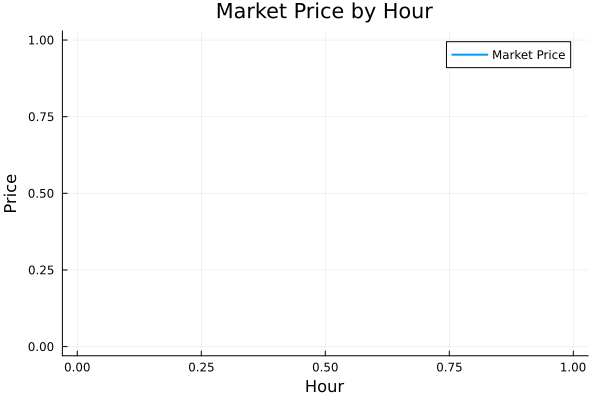

In [7]:
#plot equilibrium_df market_price in a line plot
using Plots
plot(equilibrium_df.hour, equilibrium_df.market_price, label="Market Price", xlabel="Hour", ylabel="Price", title="Market Price by Hour", lw=2)

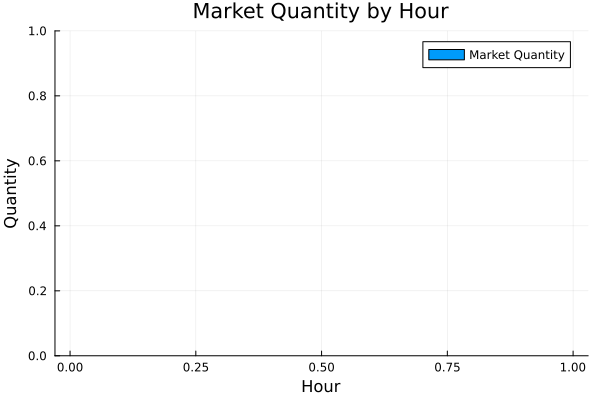

In [8]:
#plot equilibrium_df market_quantity in a bar chart
bar(equilibrium_df.hour, equilibrium_df.market_quantity, label="Market Quantity", xlabel="Hour", ylabel="Quantity", title="Market Quantity by Hour")

In [9]:
#save result_df to csv
CSV.write("results/market_clearing_model2.csv", result_df)

"results/market_clearing_model2.csv"